In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFECV
from skforecast.model_selection import select_features

import plotly
import plotly.graph_objects as go


from astral import LocationInfo
from astral.sun import sun


In [33]:
from custom_utils import *

In [34]:
def get_raw_data():
    data_path = "./../data/"
    file_name = "data.csv"
    data = pd.read_csv(data_path + file_name)
    data = first_preprocess(data, data_path)
    return data

In [35]:
raw_data = get_raw_data()
raw_data.columns

d:\RA_work\timeseries_data\notebooks\custom_utils.py:110: FutureWarning:

Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



Index(['space_heating', 'hot_water', 'sockets', 'lighting', 'bld_engcons',
       'car_chargers', 'weekend', 'bank_holiday', 'day_of_month', 'year',
       'forecast_temperature', 'forecast_feelslike', 'forecast_weathertype',
       'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_visibility',
       'week_of_year', 'sine_hour', 'cos_hour', 'sine_month', 'cos_month',
       'sine_day_of_week', 'cos_day_of_week', 'sine_forecast_winddirection',
       'cos_forecast_winddirection', 'hour_spline_0', 'hour_spline_1',
       'hour_spline_2', 'hour_spline_3', 'hour_spline_4', 'hour_spline_5',
       'hour_spline_6', 'hour_spline_7', 'hour_spline_8', 'hour_spline_9',
       'hour_spline_10', 'hour_spline_11', 'hour_spline_12', 'hour_spline_13',
       'hour_spline_14', 'hour_spline_15', 'hour_spline_16', 'hour_spline_17',
       'hour_spline_18', 'hour_spline_19', 'hour_spline_20', 'hour_spline_21',
       'hour_spline_22', 'hour_spline_23', 'mont

In [36]:
def get_year_split(df, year, col_name):
    df = df[[col_name]]
    df.loc[:, "year"] = df.index.year
    year_df = df[df["year"] == year]
    year_df = year_df.rename(columns={f"{col_name}": f"{col_name}_{year}"})
    year_df.loc[:, "time"] = year_df.index.time
    year_df.loc[:, "month"] = year_df.index.month
    year_df.loc[:, "day"] = year_df.index.day

    year_df = year_df.drop(columns="year")
    return year_df

In [37]:
import warnings; warnings.filterwarnings("ignore")
from datetime import datetime

In [40]:
data = raw_data.copy()
for col in ["bld_engcons"]:
    year_2021 = get_year_split(data, 2021, col).reset_index(drop=1)
    year_2022 = get_year_split(data, 2022, col).reset_index(drop=1)
    year_2023 = get_year_split(data, 2023, col).reset_index(drop=1)

    common_cols = ["time", "day", "month"]
    tmp1 = year_2021.merge(year_2022, on=common_cols, how="left").merge(year_2023, on=common_cols, how="left")

    def get_key_time(row):
        return datetime(
            year=2000,
            day=row["day"],
            month=row["month"],
            second=row["time"].second,
            hour=row["time"].hour,
            minute=row["time"].minute
        )
    
    tmp1.loc[:, "keytime"] = tmp1.apply(get_key_time, axis=1)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=tmp1["keytime"].to_numpy(), y=tmp1[f"{col}_2021"].to_numpy(),
                        mode='lines+markers',
                        name=f'{col}_2021'))
    fig.add_trace(go.Scatter(x=tmp1["keytime"].to_numpy(), y=tmp1[f"{col}_2022"].to_numpy(),
                        mode='lines+markers',
                        name=f'{col}_2022'))
    fig.add_trace(go.Scatter(x=tmp1["keytime"].to_numpy(), y=tmp1[f"{col}_2023"].to_numpy(),
                        mode='lines+markers',
                        name=f'{col}_2023'))

    fig.update_layout(title_text=f"Year on Year data in {col}")
    fig.show()

In [4]:
data1 = pd.read_csv("sh_pred.csv")
data2 = pd.read_csv("others_pred.csv")
data3 = pd.read_csv("hotwater_pred.csv")

In [5]:
data1.head()

time  sh_predictions
0  2021-01-01 02:00:00+00:00        4.886790
1  2021-01-01 03:00:00+00:00        5.312803
2  2021-01-01 04:00:00+00:00        5.297713
3  2021-01-01 05:00:00+00:00        5.131494
4  2021-01-01 06:00:00+00:00        5.199008

In [6]:
data2.head()

time  others_predictions
0  2021-01-01 02:00:00+00:00            0.201648
1  2021-01-01 03:00:00+00:00            0.201647
2  2021-01-01 04:00:00+00:00            0.205062
3  2021-01-01 05:00:00+00:00            0.201256
4  2021-01-01 06:00:00+00:00            0.201724

In [7]:
data3.head()

time  hw_predictions
0  2021-01-01 02:00:00+00:00        0.132245
1  2021-01-01 03:00:00+00:00        0.088926
2  2021-01-01 04:00:00+00:00        0.094369
3  2021-01-01 05:00:00+00:00        0.136109
4  2021-01-01 06:00:00+00:00        0.094978

In [8]:
building_data = data1.merge(data2, on="time", how="inner") # .merge(data3, on="time", how="inner")
building_data.head()

time  sh_predictions  others_predictions
0  2021-01-01 02:00:00+00:00        4.886790            0.201648
1  2021-01-01 03:00:00+00:00        5.312803            0.201647
2  2021-01-01 04:00:00+00:00        5.297713            0.205062
3  2021-01-01 05:00:00+00:00        5.131494            0.201256
4  2021-01-01 06:00:00+00:00        5.199008            0.201724

In [9]:
building_data["time"] = pd.to_datetime(building_data["time"], format="mixed")

d:\RA_work\timeseries_data\notebooks\custom_utils.py:110: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data[column] = data[column].interpolate(method="linear", limit_direction="both")


Index(['space_heating', 'hot_water', 'sockets', 'lighting', 'bld_engcons',
       'car_chargers', 'weekend', 'bank_holiday', 'day_of_month', 'year',
       'forecast_temperature', 'forecast_feelslike', 'forecast_weathertype',
       'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_visibility',
       'week_of_year', 'sine_hour', 'cos_hour', 'sine_month', 'cos_month',
       'sine_day_of_week', 'cos_day_of_week', 'sine_forecast_winddirection',
       'cos_forecast_winddirection', 'hour_spline_0', 'hour_spline_1',
       'hour_spline_2', 'hour_spline_3', 'hour_spline_4', 'hour_spline_5',
       'hour_spline_6', 'hour_spline_7', 'hour_spline_8', 'hour_spline_9',
       'hour_spline_10', 'hour_spline_11', 'hour_spline_12', 'hour_spline_13',
       'hour_spline_14', 'hour_spline_15', 'hour_spline_16', 'hour_spline_17',
       'hour_spline_18', 'hour_spline_19', 'hour_spline_20', 'hour_spline_21',
       'hour_spline_22', 'hour_spline_23', 'mont

In [11]:
exo_columns = ['forecast_temperature', 'forecast_feelslike', 
               'forecast_weathertype',
       # 'forecast_windspeed', 
       'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_visibility', 
       # 'daylight_hours',  
       # 'is_daylight', 
       'sine_hour',
       'cos_hour', 
       'sine_month', 'cos_month', 
       'sine_day_of_week', 'cos_day_of_week', 
       'sine_forecast_winddirection',
       'cos_forecast_winddirection', 
       # 'sine_sunrise_hour', 'cos_sunrise_hour', 'sine_sunset_hour', 'cos_sunset_hour'
       "week_of_year",
       'hour_spline_0', 'hour_spline_1',
       'hour_spline_2', 'hour_spline_3', 'hour_spline_4', 'hour_spline_5',
       'hour_spline_6', 'hour_spline_7', 'hour_spline_8', 'hour_spline_9',
       'hour_spline_10', 'hour_spline_11', 'hour_spline_12', 'hour_spline_13',
       'hour_spline_14', 'hour_spline_15', 'hour_spline_16', 'hour_spline_17',
       'hour_spline_18', 'hour_spline_19', 'hour_spline_20', 'hour_spline_21',
       'hour_spline_22', 'hour_spline_23', 'month_spline_0', 'month_spline_1',
       'month_spline_2', 'month_spline_3', 'month_spline_4', 'month_spline_5',
       'month_spline_6', 'month_spline_7', 'month_spline_8', 'month_spline_9',
       'month_spline_10', 'month_spline_11', 'day_of_week_spline_0',
       'day_of_week_spline_1', 'day_of_week_spline_2', 'day_of_week_spline_3',
       'day_of_week_spline_4', 'day_of_week_spline_5', 'day_of_week_spline_6'
       ]
endo_columns = ['weekend',] # "month", "day_of_week"] # 'bank_holiday']

subset_data = raw_data[exo_columns + endo_columns + ["bld_engcons"]]
subset_data.head()

forecast_temperature  forecast_feelslike  \
datetime                                                              
2021-01-01 00:00:00+00:00                   3.0                -1.0   
2021-01-01 01:00:00+00:00                   3.0                -1.0   
2021-01-01 02:00:00+00:00                   3.0                -1.0   
2021-01-01 03:00:00+00:00                   2.0                -2.0   
2021-01-01 04:00:00+00:00                   2.0                -2.0   

                           forecast_weathertype  forecast_uvindex  \
datetime                                                            
2021-01-01 00:00:00+00:00                   2.0               0.0   
2021-01-01 01:00:00+00:00                   2.0               0.0   
2021-01-01 02:00:00+00:00                   2.0               0.0   
2021-01-01 03:00:00+00:00                   0.0               0.0   
2021-01-01 04:00:00+00:00                   0.0               0.0   

                           forecast_precipitationprobability  \
datetime                                                       
2021-01-01 00:00:00+00:00                                0.0   
2021-01-01 01:00:00+00:00                                0.0   
2021-01-01 02:00:00+00:00                                1.0   
2021-01-01 03:00:00+00:00                                1.0   
2021-01-01 04:00:00+00:00                                1.0   

                           forecast_visibility  sine_hour  cos_hour  \
datetime                                                              
2021-01-01 00:00:00+00:00                    5   0.000000  1.000000   
2021-01-01 01:00:00+00:00                    5   0.258819  0.965926   
2021-01-01 02:00:00+00:00                    5   0.500000  0.866025   
2021-01-01 03:00:00+00:00                    5   0.707107  0.707107   
2021-01-01 04:00:00+00:00                    5   0.866025  0.500000   

                           sine_month  cos_month  ...  month_spline_11  \
datetime                                          ...                    
2021-01-01 00:00:00+00:00         0.5   0.866025  ...              0.0   
2021-01-01 01:00:00+00:00         0.5   0.866025  ...              0.0   
2021-01-01 02:00:00+00:00         0.5   0.866025  ...              0.0   
2021-01-01 03:00:00+00:00         0.5   0.866025  ...              0.0   
2021-01-01 04:00:00+00:00         0.5   0.866025  ...              0.0   

                           day_of_week_spline_0  day_of_week_spline_1  \
datetime                                                                
2021-01-01 00:00:00+00:00              0.166667                   0.0   
2021-01-01 01:00:00+00:00              0.166667                   0.0   
2021-01-01 02:00:00+00:00              0.166667                   0.0   
2021-01-01 03:00:00+00:00              0.166667                   0.0   
2021-01-01 04:00:00+00:00              0.166667                   0.0   

                           day_of_week_spline_2  day_of_week_spline_3  \
datetime                                                                
2021-01-01 00:00:00+00:00                   0.0                   0.0   
2021-01-01 01:00:00+00:00                   0.0                   0.0   
2021-01-01 02:00:00+00:00                   0.0                   0.0   
2021-01-01 03:00:00+00:00                   0.0                   0.0   
2021-01-01 04:00:00+00:00                   0.0                   0.0   

                           day_of_week_spline_4  day_of_week_spline_5  \
datetime                                                                
2021-01-01 00:00:00+00:00                   0.0              0.166667   
2021-01-01 01:00:00+00:00                   0.0              0.166667   
2021-01-01 02:00:00+00:00                   0.0              0.166667   
2021-01-01 03:00:00+00:00                   0.0              0.166667   
2021-01-01 04:00:00+00:00                   0.0              0.166667   

                           day_of_week_spli

In [12]:
subset_data.index.names = ['time']
subset_data.head()

forecast_temperature  forecast_feelslike  \
time                                                                  
2021-01-01 00:00:00+00:00                   3.0                -1.0   
2021-01-01 01:00:00+00:00                   3.0                -1.0   
2021-01-01 02:00:00+00:00                   3.0                -1.0   
2021-01-01 03:00:00+00:00                   2.0                -2.0   
2021-01-01 04:00:00+00:00                   2.0                -2.0   

                           forecast_weathertype  forecast_uvindex  \
time                                                                
2021-01-01 00:00:00+00:00                   2.0               0.0   
2021-01-01 01:00:00+00:00                   2.0               0.0   
2021-01-01 02:00:00+00:00                   2.0               0.0   
2021-01-01 03:00:00+00:00                   0.0               0.0   
2021-01-01 04:00:00+00:00                   0.0               0.0   

                           forecast_precipitationprobability  \
time                                                           
2021-01-01 00:00:00+00:00                                0.0   
2021-01-01 01:00:00+00:00                                0.0   
2021-01-01 02:00:00+00:00                                1.0   
2021-01-01 03:00:00+00:00                                1.0   
2021-01-01 04:00:00+00:00                                1.0   

                           forecast_visibility  sine_hour  cos_hour  \
time                                                                  
2021-01-01 00:00:00+00:00                    5   0.000000  1.000000   
2021-01-01 01:00:00+00:00                    5   0.258819  0.965926   
2021-01-01 02:00:00+00:00                    5   0.500000  0.866025   
2021-01-01 03:00:00+00:00                    5   0.707107  0.707107   
2021-01-01 04:00:00+00:00                    5   0.866025  0.500000   

                           sine_month  cos_month  ...  month_spline_11  \
time                                              ...                    
2021-01-01 00:00:00+00:00         0.5   0.866025  ...              0.0   
2021-01-01 01:00:00+00:00         0.5   0.866025  ...              0.0   
2021-01-01 02:00:00+00:00         0.5   0.866025  ...              0.0   
2021-01-01 03:00:00+00:00         0.5   0.866025  ...              0.0   
2021-01-01 04:00:00+00:00         0.5   0.866025  ...              0.0   

                           day_of_week_spline_0  day_of_week_spline_1  \
time                                                                    
2021-01-01 00:00:00+00:00              0.166667                   0.0   
2021-01-01 01:00:00+00:00              0.166667                   0.0   
2021-01-01 02:00:00+00:00              0.166667                   0.0   
2021-01-01 03:00:00+00:00              0.166667                   0.0   
2021-01-01 04:00:00+00:00              0.166667                   0.0   

                           day_of_week_spline_2  day_of_week_spline_3  \
time                                                                    
2021-01-01 00:00:00+00:00                   0.0                   0.0   
2021-01-01 01:00:00+00:00                   0.0                   0.0   
2021-01-01 02:00:00+00:00                   0.0                   0.0   
2021-01-01 03:00:00+00:00                   0.0                   0.0   
2021-01-01 04:00:00+00:00                   0.0                   0.0   

                           day_of_week_spline_4  day_of_week_spline_5  \
time                                                                    
2021-01-01 00:00:00+00:00                   0.0              0.166667   
2021-01-01 01:00:00+00:00                   0.0              0.166667   
2021-01-01 02:00:00+00:00                   0.0              0.166667   
2021-01-01 03:00:00+00:00                   0.0              0.166667   
2021-01-01 04:00:00+00:00                   0.0              0.166667   

                           day_of_week_spli

In [13]:
tmp1 = subset_data.reset_index(drop=0)
tmp2 = building_data.copy()

In [14]:
building_data = tmp1.merge(tmp2, on="time", how="left")
building_data.isna().sum()

time                    0
forecast_temperature    0
forecast_feelslike      0
forecast_weathertype    0
forecast_uvindex        0
                       ..
day_of_week_spline_6    0
weekend                 0
bld_engcons             0
sh_predictions          3
others_predictions      3
Length: 63, dtype: int64

In [15]:
building_data["sh_predictions"] = building_data["sh_predictions"].interpolate(limit_direction="both", method="linear")
building_data["others_predictions"] = building_data["others_predictions"].interpolate(limit_direction="both", method="linear")
# building_data["hw_predictions"] = building_data["hw_predictions"].interpolate(limit_direction="both", method="linear")

In [16]:
building_data = building_data.set_index("time")
building_data = building_data.asfreq("h")

In [17]:
building_data.head()

forecast_temperature  forecast_feelslike  \
time                                                                  
2021-01-01 00:00:00+00:00                   3.0                -1.0   
2021-01-01 01:00:00+00:00                   3.0                -1.0   
2021-01-01 02:00:00+00:00                   3.0                -1.0   
2021-01-01 03:00:00+00:00                   2.0                -2.0   
2021-01-01 04:00:00+00:00                   2.0                -2.0   

                           forecast_weathertype  forecast_uvindex  \
time                                                                
2021-01-01 00:00:00+00:00                   2.0               0.0   
2021-01-01 01:00:00+00:00                   2.0               0.0   
2021-01-01 02:00:00+00:00                   2.0               0.0   
2021-01-01 03:00:00+00:00                   0.0               0.0   
2021-01-01 04:00:00+00:00                   0.0               0.0   

                           forecast_precipitationprobability  \
time                                                           
2021-01-01 00:00:00+00:00                                0.0   
2021-01-01 01:00:00+00:00                                0.0   
2021-01-01 02:00:00+00:00                                1.0   
2021-01-01 03:00:00+00:00                                1.0   
2021-01-01 04:00:00+00:00                                1.0   

                           forecast_visibility  sine_hour  cos_hour  \
time                                                                  
2021-01-01 00:00:00+00:00                    5   0.000000  1.000000   
2021-01-01 01:00:00+00:00                    5   0.258819  0.965926   
2021-01-01 02:00:00+00:00                    5   0.500000  0.866025   
2021-01-01 03:00:00+00:00                    5   0.707107  0.707107   
2021-01-01 04:00:00+00:00                    5   0.866025  0.500000   

                           sine_month  cos_month  ...  day_of_week_spline_1  \
time                                              ...                         
2021-01-01 00:00:00+00:00         0.5   0.866025  ...                   0.0   
2021-01-01 01:00:00+00:00         0.5   0.866025  ...                   0.0   
2021-01-01 02:00:00+00:00         0.5   0.866025  ...                   0.0   
2021-01-01 03:00:00+00:00         0.5   0.866025  ...                   0.0   
2021-01-01 04:00:00+00:00         0.5   0.866025  ...                   0.0   

                           day_of_week_spline_2  day_of_week_spline_3  \
time                                                                    
2021-01-01 00:00:00+00:00                   0.0                   0.0   
2021-01-01 01:00:00+00:00                   0.0                   0.0   
2021-01-01 02:00:00+00:00                   0.0                   0.0   
2021-01-01 03:00:00+00:00                   0.0                   0.0   
2021-01-01 04:00:00+00:00                   0.0                   0.0   

                           day_of_week_spline_4  day_of_week_spline_5  \
time                                                                    
2021-01-01 00:00:00+00:00                   0.0              0.166667   
2021-01-01 01:00:00+00:00                   0.0              0.166667   
2021-01-01 02:00:00+00:00                   0.0              0.166667   
2021-01-01 03:00:00+00:00                   0.0              0.166667   
2021-01-01 04:00:00+00:00                   0.0              0.166667   

                           day_of_week_spline_6  weekend  bld_engcons  \
time                                                                    
2021-01-01 00:00:00+00:00              0.666667        0     3.629499   
2021-01-01 01:00:00+00:00              0.666667        0     4.215506   
2021-01-01 02:00:00+00:00              0.666667        0     5.994066   
2021-01-01 03:00:00+00:00              0.666667        0     5.954252   
2021-01-01 04:00:00+00:00              0.666667        0     5.620296   

        

In [18]:
bldg_columns = exo_columns + endo_columns + ["sh_predictions", "others_predictions", # "hw_predictions"
                                             ] + ["bld_engcons"]

# bld_data_scaler, bld_transformed_data = create_std_scaler(building_data, bldg_columns[:-1])
# bld_target_scaler, bld_transformed_target_data = create_std_scaler(building_data, bldg_columns[-1])

# bld_transformed_data = pd.merge(
#     bld_transformed_data, bld_transformed_target_data,
#     left_index=True,
#     right_index=True
# )

# building_train_data = bld_transformed_data[bld_transformed_data.index < "2023-01-01"]
# building_test_data = bld_transformed_data[bld_transformed_data.index >= "2023-01-01"]                            
building_train_data = building_data[building_data.index < "2023-01-01"]
building_test_data = building_data[building_data.index >= "2023-01-01"]                   

In [19]:
building_train_data.head()

forecast_temperature  forecast_feelslike  \
time                                                                  
2021-01-01 00:00:00+00:00                   3.0                -1.0   
2021-01-01 01:00:00+00:00                   3.0                -1.0   
2021-01-01 02:00:00+00:00                   3.0                -1.0   
2021-01-01 03:00:00+00:00                   2.0                -2.0   
2021-01-01 04:00:00+00:00                   2.0                -2.0   

                           forecast_weathertype  forecast_uvindex  \
time                                                                
2021-01-01 00:00:00+00:00                   2.0               0.0   
2021-01-01 01:00:00+00:00                   2.0               0.0   
2021-01-01 02:00:00+00:00                   2.0               0.0   
2021-01-01 03:00:00+00:00                   0.0               0.0   
2021-01-01 04:00:00+00:00                   0.0               0.0   

                           forecast_precipitationprobability  \
time                                                           
2021-01-01 00:00:00+00:00                                0.0   
2021-01-01 01:00:00+00:00                                0.0   
2021-01-01 02:00:00+00:00                                1.0   
2021-01-01 03:00:00+00:00                                1.0   
2021-01-01 04:00:00+00:00                                1.0   

                           forecast_visibility  sine_hour  cos_hour  \
time                                                                  
2021-01-01 00:00:00+00:00                    5   0.000000  1.000000   
2021-01-01 01:00:00+00:00                    5   0.258819  0.965926   
2021-01-01 02:00:00+00:00                    5   0.500000  0.866025   
2021-01-01 03:00:00+00:00                    5   0.707107  0.707107   
2021-01-01 04:00:00+00:00                    5   0.866025  0.500000   

                           sine_month  cos_month  ...  day_of_week_spline_1  \
time                                              ...                         
2021-01-01 00:00:00+00:00         0.5   0.866025  ...                   0.0   
2021-01-01 01:00:00+00:00         0.5   0.866025  ...                   0.0   
2021-01-01 02:00:00+00:00         0.5   0.866025  ...                   0.0   
2021-01-01 03:00:00+00:00         0.5   0.866025  ...                   0.0   
2021-01-01 04:00:00+00:00         0.5   0.866025  ...                   0.0   

                           day_of_week_spline_2  day_of_week_spline_3  \
time                                                                    
2021-01-01 00:00:00+00:00                   0.0                   0.0   
2021-01-01 01:00:00+00:00                   0.0                   0.0   
2021-01-01 02:00:00+00:00                   0.0                   0.0   
2021-01-01 03:00:00+00:00                   0.0                   0.0   
2021-01-01 04:00:00+00:00                   0.0                   0.0   

                           day_of_week_spline_4  day_of_week_spline_5  \
time                                                                    
2021-01-01 00:00:00+00:00                   0.0              0.166667   
2021-01-01 01:00:00+00:00                   0.0              0.166667   
2021-01-01 02:00:00+00:00                   0.0              0.166667   
2021-01-01 03:00:00+00:00                   0.0              0.166667   
2021-01-01 04:00:00+00:00                   0.0              0.166667   

                           day_of_week_spline_6  weekend  bld_engcons  \
time                                                                    
2021-01-01 00:00:00+00:00              0.666667        0     3.629499   
2021-01-01 01:00:00+00:00              0.666667        0     4.215506   
2021-01-01 02:00:00+00:00              0.666667        0     5.994066   
2021-01-01 03:00:00+00:00              0.666667        0     5.954252   
2021-01-01 04:00:00+00:00              0.666667        0     5.620296   

        

In [20]:
# bldg_forecaster = ForecasterAutoreg(regressor=LinearRegression(n_jobs=-1), lags=24)
bldg_forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(criterion="squared_error", 
                                     n_estimators=1500,
                                     max_depth=25,
                                     n_jobs=-1,
                                     max_features="sqrt"), 
    # regressor=LinearRegression(), 
    # regressor=LGBMRegressor(n_estimators=1000, learning_rate=0.03, max_depth=20),
    lags=6
)


# feature selection
regressor = LGBMRegressor(n_estimators=1000, max_depth=5, random_state=15926, verbose=-1)
selector = RFECV(
    estimator=regressor, step=1, cv=3, min_features_to_select=5, n_jobs=-1
)
selected_autoreg, selected_exog = select_features(
   forecaster         = bldg_forecaster,
   selector           = selector,
   select_only        = "exog", 
   y                  = building_train_data['bld_engcons'],
   exog               = building_train_data[exo_columns + endo_columns],
   subsample          = 0.5,
   verbose            = True
)

bldg_forecaster.fit(
    y=building_train_data['bld_engcons'],
    exog=building_train_data[selected_exog]
)

Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 17514
Total number of records used for feature selection: 8757
Number of features available: 59
    Autoreg (n=6)
    Exog    (n=59)
Number of features selected: 23
    Autoreg (n=6) : [1, 2, 3, 4, 5, 6]
    Exog    (n=23) : ['forecast_temperature', 'forecast_feelslike', 'forecast_weathertype', 'forecast_uvindex', 'forecast_precipitationprobability', 'forecast_visibility', 'sine_hour', 'cos_hour', 'sine_month', 'cos_month', 'sine_day_of_week', 'cos_day_of_week', 'sine_forecast_winddirection', 'cos_forecast_winddirection', 'week_of_year', 'hour_spline_8', 'hour_spline_9', 'hour_spline_10', 'hour_spline_11', 'day_of_week_spline_0', 'day_of_week_spline_2', 'day_of_week_spline_4', 'weekend']


#### building forecaster training data

In [21]:
def custom_metric(y_true, y_pred):
    '''
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    '''
    return calculate_smape(actual=y_true, predicted=y_pred)

In [22]:
metric, bldg_predictions_training = backtesting_forecaster(
    forecaster         = bldg_forecaster,
    y                  = building_train_data['bld_engcons'],
    exog               = building_train_data[selected_exog],
    steps              = 1,
    metric             = custom_metric,
    initial_train_size = None,
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

print(f"Backtest error: {metric:.2f}")
bldg_predictions_training.head()

  0%|          | 0/17514 [00:00<?, ?it/s]

Backtest error: 15.41


pred
2021-01-01 06:00:00+00:00  5.564273
2021-01-01 07:00:00+00:00  5.498570
2021-01-01 08:00:00+00:00  5.363871
2021-01-01 09:00:00+00:00  5.196654
2021-01-01 10:00:00+00:00  4.983354

In [23]:
bldg_predictions_training["y"] = building_train_data["bld_engcons"]
bldg_predictions_training = bldg_predictions_training.reset_index(drop=0)
# bldg_predictions_training[["pred", "y"]] = bld_target_scaler.inverse_transform(bldg_predictions_training[["pred", "y"]])
bldg_predictions_training = bldg_predictions_training.rename(columns={"index": "time"})

bldg_predictions_training.head()

time      pred         y
0 2021-01-01 06:00:00+00:00  5.564273  5.704551
1 2021-01-01 07:00:00+00:00  5.498570  5.607749
2 2021-01-01 08:00:00+00:00  5.363871  5.471502
3 2021-01-01 09:00:00+00:00  5.196654  5.459690
4 2021-01-01 10:00:00+00:00  4.983354  5.429498

In [24]:
def plot_predictions(plot_data, title_text):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=plot_data["time"].to_numpy(), y=plot_data["y"].to_numpy(),
                        mode='lines+markers',
                        name='actual'))
    fig.add_trace(go.Scatter(x=plot_data["time"].to_numpy(), y=plot_data["pred"].to_numpy(),
                        mode='lines+markers',
                        name='predictions'))
    fig.update_layout(title_text=title_text)
    fig.show()

In [25]:
plot_predictions(bldg_predictions_training, title_text="Building engergy consumption Training data")

#### building forecaster testing data with refit

In [26]:
metric, bldg_predictions = backtesting_forecaster(
    forecaster         = bldg_forecaster,
    y                  = building_data['bld_engcons'],
    exog               = building_data[selected_exog],
    steps              = 1,
    metric             = custom_metric,
    initial_train_size = building_data[building_data.index < "2023-01-01"].shape[0],
    refit              = 1000, 
    fixed_train_size   = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

print(f"Backtest error: {metric:.2f}")
bldg_predictions.head()

  0%|          | 0/8760 [00:00<?, ?it/s]

Backtest error: 26.20


pred
2023-01-01 00:00:00+00:00  1.179390
2023-01-01 01:00:00+00:00  2.629131
2023-01-01 02:00:00+00:00  2.837158
2023-01-01 03:00:00+00:00  2.354775
2023-01-01 04:00:00+00:00  2.513952

In [27]:
bldg_predictions.head()

pred
2023-01-01 00:00:00+00:00  1.179390
2023-01-01 01:00:00+00:00  2.629131
2023-01-01 02:00:00+00:00  2.837158
2023-01-01 03:00:00+00:00  2.354775
2023-01-01 04:00:00+00:00  2.513952

In [28]:
bldg_predictions["y"] = building_test_data["bld_engcons"]
bldg_predictions = bldg_predictions.reset_index(drop=0)
# bldg_predictions[["pred", "y"]] = bld_target_scaler.inverse_transform(bldg_predictions[["pred", "y"]])
bldg_predictions = bldg_predictions.rename(columns={"index": "time"})
bldg_predictions.head()

plot_predictions(bldg_predictions, title_text="Building engergy consumption Testing data")

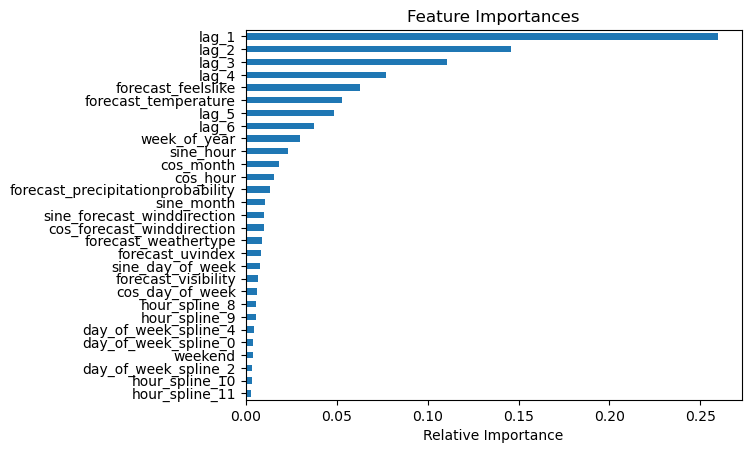

In [29]:
feat_importances = pd.Series(bldg_forecaster.regressor.feature_importances_, 
                             index=bldg_forecaster.regressor.feature_names_in_)
feat_importances.sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

#### Metrics

In [30]:
cal_metrics(bldg_predictions_training["pred"].to_numpy(), bldg_predictions_training["y"].to_numpy())

MAE   MAPE  R2_Score  SMAPE     nRMSE      RMSE  MASE
0  0.152217  14.05  0.961069  15.41  0.028651  0.239988 -0.15

In [31]:
cal_metrics(bldg_predictions["pred"].to_numpy(), bldg_predictions["y"].to_numpy())

MAE   MAPE  R2_Score  SMAPE     nRMSE     RMSE  MASE
0  0.443156  27.77  0.537389   26.2  0.105399  0.69502 -0.44

##### preious value without spline
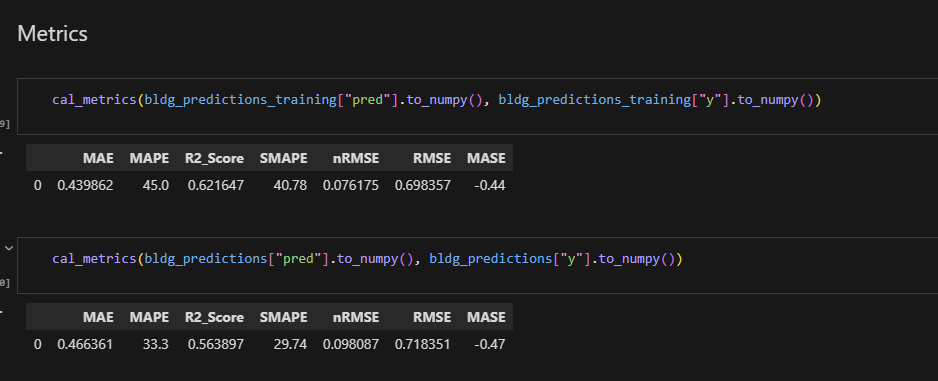

#### Explore Error / Residual

In [ ]:
assert (bldg_predictions[bldg_predictions["pred"] <= 0].shape[0] > 0) == False

In [ ]:
q1_2023 = bldg_predictions[(bldg_predictions["time"] >= "2023-01-01") & (bldg_predictions["time"] < "2023-04-01")]  # jan - fev - march 
q2_2023 = bldg_predictions[(bldg_predictions["time"] >= "2023-04-01") & (bldg_predictions["time"] < "2023-07-01")] # april - may - june
q3_2023 = bldg_predictions[(bldg_predictions["time"] >= "2023-07-01") & (bldg_predictions["time"] < "2023-10-01")] # july - aug - sept
q4_2023 = bldg_predictions[(bldg_predictions["time"] >= "2023-10-01") & (bldg_predictions["time"] <= "2023-12-31")] # oct - nov - dec

q1_2023.shape, q2_2023.shape, q3_2023.shape, q4_2023.shape 

In [ ]:
q1_2022 = bldg_predictions_training[(bldg_predictions_training["time"] >= "2022-01-01") & (bldg_predictions_training["time"] < "2022-04-01")]  # jan - fev - march 
q2_2022 = bldg_predictions_training[(bldg_predictions_training["time"] >= "2022-04-01") & (bldg_predictions_training["time"] < "2022-07-01")] # april - may - june
q3_2022 = bldg_predictions_training[(bldg_predictions_training["time"] >= "2022-07-01") & (bldg_predictions_training["time"] < "2022-10-01")] # july - aug - sept
q4_2022 = bldg_predictions_training[(bldg_predictions_training["time"] >= "2022-10-01") & (bldg_predictions_training["time"] <= "2022-12-31")] # oct - nov - dec

q1_2022.shape, q2_2022.shape, q3_2022.shape, q4_2022.shape 

In [ ]:
q1_2021 = bldg_predictions_training[bldg_predictions_training["time"] < "2021-04-01"]  # jan - fev - march 
q2_2021 = bldg_predictions_training[(bldg_predictions_training["time"] >= "2021-04-01") & (bldg_predictions_training["time"] < "2021-07-01")] # april - may - june
q3_2021 = bldg_predictions_training[(bldg_predictions_training["time"] >= "2021-07-01") & (bldg_predictions_training["time"] < "2021-10-01")] # july - aug - sept
q4_2021 = bldg_predictions_training[(bldg_predictions_training["time"] >= "2021-10-01") & (bldg_predictions_training["time"] <= "2021-12-31")] # oct - nov - dec

q1_2021.shape, q2_2021.shape, q3_2021.shape, q4_2021.shape 

In [ ]:
q_df = pd.DataFrame({})

def print_metrics(q_list, year):
    global q_df
    for idx, quar in enumerate(q_list):
        m_df = cal_metrics(quar["pred"].to_numpy(), quar["y"].to_numpy())
        m_df["year"] = year
        m_df["quarter"] = idx +1
        q_df = pd.concat([q_df, m_df], axis=0).reset_index(drop=1)

In [ ]:
print_metrics([q1_2023, q2_2023, q3_2023, q4_2023], "2023")
print_metrics([q1_2022, q2_2022, q3_2022, q4_2022], "2022")
print_metrics([q1_2021, q2_2021, q3_2021, q4_2021], "2021")

In [ ]:
q_df

In [ ]:
sns.catplot(data=q_df, x='year', y='SMAPE', hue='quarter', kind='bar', palette="pastel")

In [ ]:
def _plot_dist(quar, year, idx):
    # distribution plot
    ax = sns.displot(data=quar["error"])
    plt.title(f"Residual distribution for {year}: Q{idx + 1}")
    plt.tight_layout()
    plt.savefig(f".././assets/error_plots/{year}_Q{idx + 1}.jpeg", format="jpeg")
    plt.show()


def _plot_box(quar,  year, idx):
    # error plot
    ax = sns.boxplot(data=quar[["error"]])
    plt.title(f"Outliers for {year}: Q{idx + 1}")
    plt.tight_layout()
    plt.savefig(f".././assets/error_plots/{year}_Q{idx + 1}_outlier.jpeg", format="jpeg")
    plt.show()

def plot_dist(q_list, year):
    for idx, quar in enumerate(q_list):
        quar.loc[:, "error"] = quar["pred"] - quar["y"]

        _plot_dist(quar, year, idx)

        _plot_box(quar, year, idx)

In [ ]:
plot_dist([q1_2021, q2_2021, q3_2021, q4_2021], "2021")
plot_dist([q1_2022, q2_2022, q3_2022, q4_2022], "2022")
plot_dist([q1_2023, q2_2023, q3_2023, q4_2023], "2023")

##### Apply cutoffs from error analysis and outlier analysis

In [ ]:
data_mapping = {
    "2021": {"data": [q1_2021, q2_2021, q3_2021, q4_2021], 
             "error_cutoffs": [(-0.2, 0.2), (-0.1, 0.1), (-0.1,0.1), (-0.2, 0.2)]},
    "2022": {"data": [q1_2022, q2_2022, q3_2022, q4_2022], 
             "error_cutoffs": [(-0.2, 0.2), (-0.1, 0.1), (-0.1, 0.1), (-0.2, 0.2)]},
    "2023": {"data": [q1_2023, q2_2023, q3_2023, q4_2023], 
             "error_cutoffs": [(-2, 2), (-1, 1), (-0.75, 0.75), (-1.75, 1.75)]}
}

In [ ]:
def apply_error_cutoffs(q_list, error_cutoffs):
    subset_qlist = []
    for quar, cutoff in zip(q_list, error_cutoffs):
        quar.loc[:, "error"] = quar['pred'] - quar["y"]
        quar = quar[(quar["error"] >= cutoff[0]) & (quar["error"] <= cutoff[1])]
        subset_qlist.append(quar)
    return subset_qlist

In [ ]:
q_df = pd.DataFrame({})
for year in data_mapping:
    data = apply_error_cutoffs(data_mapping[year]["data"], data_mapping[year]["error_cutoffs"])
    print_metrics(data, year)

In [ ]:
q_df

In [ ]:
sns.catplot(data=q_df, x='year', y='SMAPE', hue='quarter', kind='bar', palette="pastel")

In [ ]:
sns.catplot(data=q_df, x='year', y='nRMSE', hue='quarter', kind='bar', palette="pastel")

In [ ]:
sns.catplot(data=q_df, x='year', y='RMSE', hue='quarter', kind='bar', palette="pastel")

#### Explore prediction intervals

In [ ]:
bldg_forecaster

In [ ]:
prob_intervals = bldg_forecaster.predict_interval(
    steps    = building_test_data.shape[0],
    exog = building_test_data[bldg_columns[:-1]],
    interval = [5, 95],
    n_boot   = 200
)

In [ ]:
# prob_intervals[['pred', "lower_bound", "upper_bound"]] = bld_target_scaler.inverse_transform(prob_intervals[["pred", "lower_bound", "upper_bound"]])

In [ ]:
# prob_intervals[["actual"]] = bld_target_scaler.inverse_transform(building_test_data[["bld_engcons"]])
# prob_intervals.head()

In [ ]:
plot_data = prob_intervals.reset_index(drop=0)
plot_data = plot_data.rename(columns={"index": "time"})
plot_data.head()

In [ ]:
def plot_predictions_intervals(plot_data, title_text):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=plot_data["time"].to_numpy(), y=plot_data["actual"].to_numpy(),
                        mode='lines+markers',
                        name='actual',
                        marker=dict(color="green")))
    fig.add_trace(go.Scatter(x=plot_data["time"].to_numpy(), y=plot_data["pred"].to_numpy(),
                        mode='lines+markers',
                        name='predictions',
                        marker=dict(color="blue")))
    fig.add_trace(go.Scatter(x=plot_data["time"].to_numpy(), y=plot_data["lower_bound"].to_numpy(),
                        mode='lines',
                        marker=dict(color="red"),
                        line=dict(width=0),
                        showlegend=False,
                        name="lower bound",
                       fillcolor='rgba(240, 67, 176, 0.3)',
                       fill='tonexty'))
    fig.add_trace(go.Scatter(x=plot_data["time"].to_numpy(), y=plot_data["upper_bound"].to_numpy(),
                        mode='lines',
                        marker=dict(color="red"),
                        line=dict(width=0),
                        showlegend=False,
                        name="upper bound", 
                        fillcolor='rgba(240, 67, 176, 0.3)',
                       fill='tonexty'))
    fig.update_layout(
        yaxis_title="Energy Consumption in KWh",
        title_text=title_text, 
        hovermode="x"
    )
    fig.show()
    asset_path = '.././assets/'
    file_name = 'composite_model_4b.html'
    plotly.offline.plot(fig, filename=asset_path + file_name)

In [ ]:
plot_predictions_intervals(plot_data, "Building Energy Conumption Prediction Year 2023")